Mehrdad Ardi - AI Mastery - Semester 5
- Comparative Performance Analysis of simple Linear Regression Models, Multiple Linear Regression , Polynomial Regression, Ridge Regression, Lasso Regression, and Elastic Net Regression.

In [1]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('/content/drive/MyDrive/datasets/used_cars.csv')
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


# Exploratory data analysis

In [12]:
df.head()
df.shape
df.columns
df.duplicated().sum()
df.nunique()
df.info()
df.describe()
df.corr(numeric_only=True)
df['seller_type'].value_counts().to_frame()

,count
seller_type,
Individual,6766
Dealer,1126
Trustmark Dealer,236


In [13]:
# Remove 'name' column
df.drop(['name'], axis=1, inplace=True)

# Remove duplicate rows
df.drop_duplicates(keep='first', inplace=True)

# Extract numeric values from 'mileage', 'engine', 'max_power', and 'torque'
df['mileage'] = df['mileage'].str.extract(r'^(\d+\.?\d*)')
df['engine'] = df['engine'].str.extract(r'^(\d+)')
df['max_power'] = df['max_power'].str.extract(r'^(\d+\.?\d*)')
df['torque'] = df['torque'].str.extract(r'(\d+\.?\d*)\s?[Nn][Mm]')

# Convert the columns to numerical type
df = df.astype({
    'mileage': 'float64',
    'engine': 'Int64',
    'max_power': 'float64',
    'torque': 'float64'
})

df.describe()

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats
count,6907.000000,6.907000e+03,6.907000e+03,6699.000000,6699.0,6701.000000,6208.000000,6699.000000
mean,2013.416679,5.174456e+05,7.400715e+04,19.464360,1431.04732,87.748026,171.567448,5.434393
std,4.080794,5.203562e+05,5.836081e+04,4.050454,493.365463,31.785609,85.919576,0.984496
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.0,0.000000,48.000000,2.000000
25%,2011.000000,2.500000e+05,4.000000e+04,16.800000,1197.0,67.100000,110.000000,5.000000
50%,2014.000000,4.000000e+05,7.000000e+04,19.440000,1248.0,81.830000,160.000000,5.000000
75%,2017.000000,6.345000e+05,1.000000e+05,22.500000,1498.0,100.000000,200.000000,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.0,400.000000,789.000000,14.000000


In [14]:
# Replace zero values in 'max_power' and 'mileage' columns with NaN.
# Zero values in these columns are invalid data.
df['max_power'].replace(0, pd.NA, inplace=True)
df['mileage'].replace(0, pd.NA, inplace=True)

In [15]:
# Handle mssing values
if df.isnull().sum().sum():

  # Remove rows with at most 70% missing values
  thresh = int(len(df.columns)*0.3)
  df.dropna(thresh=thresh, inplace=True)

  # Remove columns with at most 80% missing values
  thresh = int(len(df)*0.2)
  df.dropna(thresh=thresh, axis=1,inplace=True)

  # Fill missing values
  df.fillna({
      'year': df.year.mode()[0],
      'selling_price': int(df.selling_price.mean()),
      'km_driven': int(df.km_driven.mean()),
      'fuel': df.fuel.mode()[0],
      'seller_type': df.seller_type.mode()[0],
      'transmission': df.transmission.mode()[0],
      'owner': df.owner.mode()[0],
      'mileage': df.mileage.mean(),
      'engine': int(df.engine.mean()),
      'max_power': df.max_power.mean(),
      'torque': df.torque.mean(),
      'seats': df.seats.mode()[0]
  }, inplace=True)

In [16]:
# Create a new feature 'power_price_ratio'
df['price_power_ratio'] = df['selling_price'] / (df['max_power'] )

In [17]:
# Handle outliers
columns = ['selling_price','km_driven', 'mileage', 'engine', 'max_power', 'torque', 'price_power_ratio']
for feature in columns:
  Q1 = df[feature].quantile(0.25)
  Q3 = df[feature].quantile(0.75)
  IQR = Q3-Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  mask = (df[feature] < lower_bound) | (df[feature] > upper_bound)
  outliers = df[mask]

  if not outliers.empty:
    df[feature] = df[feature].clip(lower=int(lower_bound), upper=int(upper_bound))

In [18]:
df_copy = df.copy() # make a copy of data frame to use in visualization

# Label encode categorical columns
categorical_features = ['fuel','seller_type','transmission','owner']
label_encoder = LabelEncoder()
for feature in categorical_features:
  df[feature] = label_encoder.fit_transform(df[feature])


In [19]:
# Feature scaling
scaler = MinMaxScaler()
features = df.columns
df[features] = scaler.fit_transform(df[features])

# Data Visualization

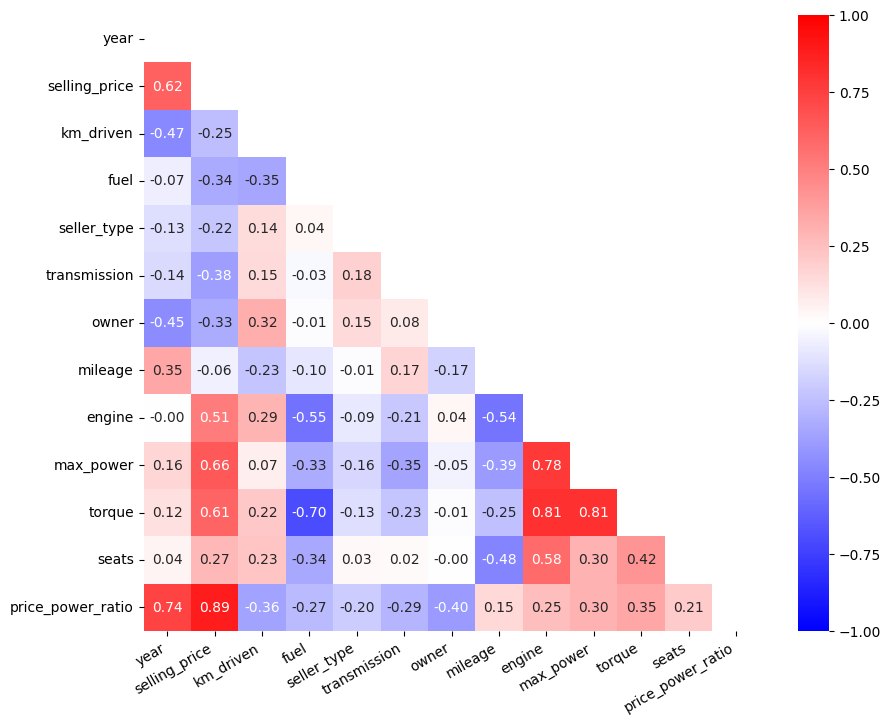

In [20]:
# visualize the correlation heatmap between features
plt.figure(figsize=(10, 8))
corr = df.corr()
mask = np.triu(corr)
sns.heatmap(corr, vmin=-1, vmax=1, square=True, mask=mask, cmap='bwr', annot=True, fmt='.2f')
plt.xticks(rotation=30, ha='right')
plt.show()

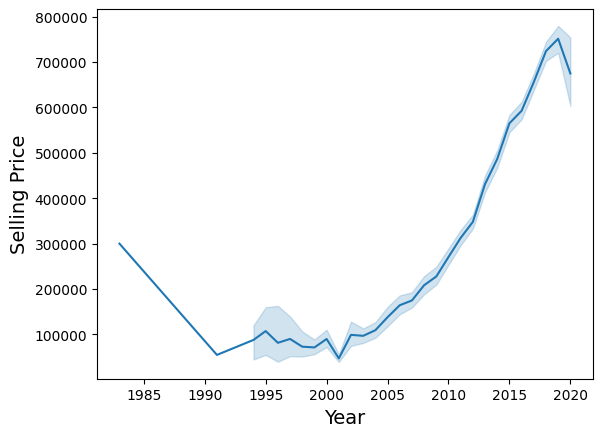

In [21]:
# Line plot
plt.xlabel('Year', fontsize=14)
plt.ylabel('Selling Price', fontsize=14)
sns.lineplot(x='year', y='selling_price', data=df_copy)
# Set y-axis tick label format to non-scientific notation
plt.ticklabel_format(style='plain', axis='y')
plt.show()

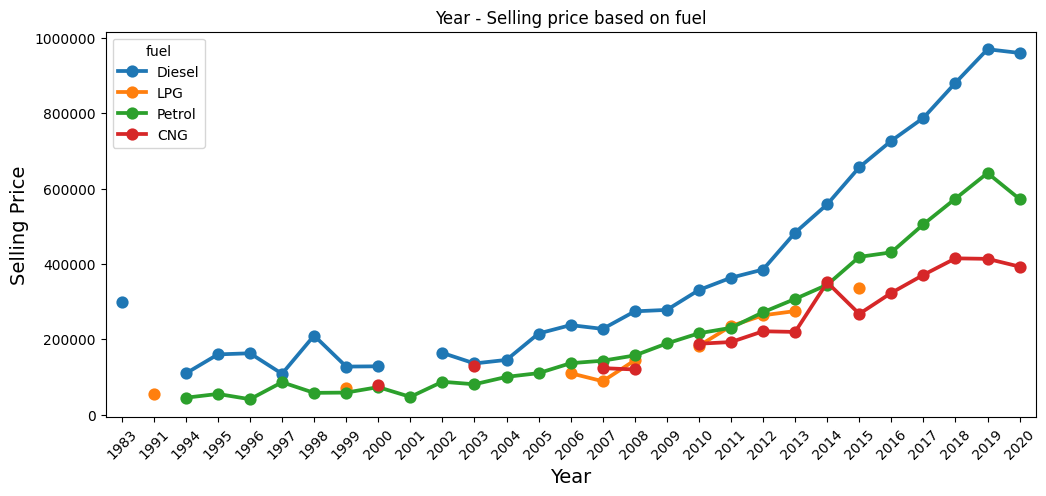

In [22]:
# Point plot
plt.figure(figsize=(12,5))
sns.pointplot(x='year', y='selling_price', hue='fuel', data=df_copy, errorbar=None)
plt.title('Year - Selling price based on fuel')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Selling Price', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.show()

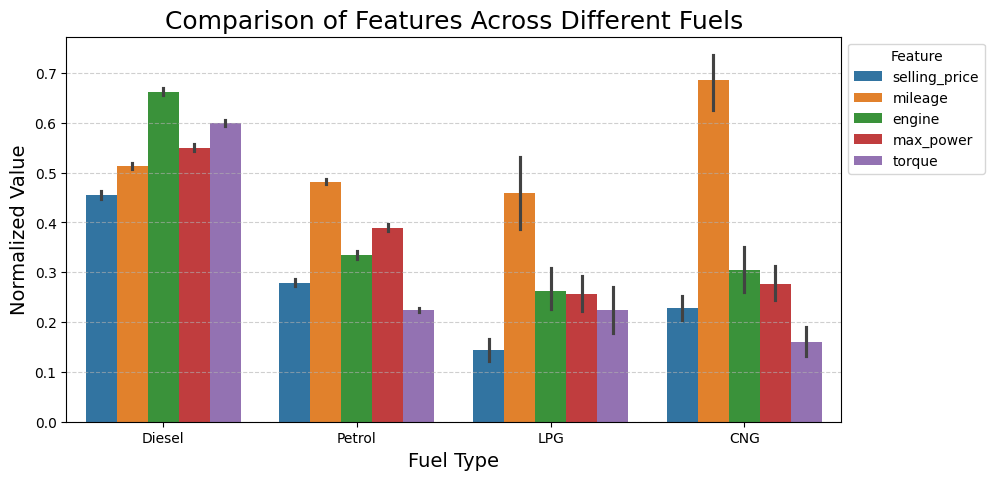

In [23]:
# Bar plot
df_barplot = df.copy()
df_barplot['fuel'] = df_copy['fuel']

features = ['selling_price', 'mileage', 'engine', 'max_power', 'torque']
df_melted = pd.melt(df_barplot, id_vars=['fuel'], value_vars=features,
                    var_name='feature', value_name='value')

plt.figure(figsize=(10, 5))

sns.barplot(data=df_melted, x='fuel', y='value', hue='feature')
plt.title('Comparison of Features Across Different Fuels', fontsize=18)
plt.xlabel('Fuel Type', fontsize=14)
plt.ylabel('Normalized Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Feature', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [24]:
# Create an empty DataFrame to save the results of each method
column_names = ['model', 'MSE', 'R-squared']
result_df = pd.DataFrame(columns=column_names)

# Simple Linear Regression

In [25]:
X = df[['price_power_ratio']]
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# mean squared error
mse = mean_squared_error(y_test,y_pred)

# R_squared score
r2 = r2_score(y_test, y_pred)

# add result
record = {'model': ['Simple Linear Regression'],
          'MSE': [f'{mse:.4f}'],
          'R-squared': [f'{r2:.4f}']}

result_df = pd.concat([result_df, pd.DataFrame(record)], ignore_index=True)

print(f"SLR -> mse : {mse:.4f} , r2 : {r2:.4f}")

SLR -> mse : 0.0124 , r2 : 0.7889


# Multiple Linear Regression

In [26]:
X = df.drop(['selling_price'], axis=1)
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# mean squared error
mse = mean_squared_error(y_test,y_pred)

# R_squared score
r2 = r2_score(y_test, y_pred)

# add result
record = {'model': ['Multiple Linear Regression'],
          'MSE': [f'{mse:.4f}'],
          'R-squared': [f'{r2:.4f}']}

result_df = pd.concat([result_df, pd.DataFrame(record)], ignore_index=True)

print(f"MLR -> mse : {mse:.4f} , r2 : {r2:.4f}")

MLR -> mse : 0.0024 , r2 : 0.9583


# Polynomial Regression

In [27]:
X = df.drop(['selling_price'], axis=1)
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pf = PolynomialFeatures(degree=3)
X_train_poly = pf.fit_transform(X_train)
X_test_poly = pf.fit_transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)

# mean squared error
mse = mean_squared_error(y_test,y_pred)

# R_squared score
r2 = r2_score(y_test, y_pred)

# add result
record = {'model': ['Polynomial Regression'],
          'MSE': [f'{mse:.4f}'],
          'R-squared': [f'{r2:.4f}']}

result_df = pd.concat([result_df, pd.DataFrame(record)], ignore_index=True)

print(f"Polynomial Regression -> mse : {mse:.4f} , r2 : {r2:.4f}")

Polynomial Regression -> mse : 0.0007 , r2 : 0.9885


# Ridge Regression

In [28]:
X = df.drop(['selling_price'], axis=1)
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use cross-validation for hyperparameter tuning
alphas = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8]
params_dict = [{'alpha': alpha} for alpha in alphas]

models = [Ridge(alpha=params['alpha']) for params in params_dict]
cv_scores = [cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
             for model in models]

best_model_index = np.argmax(cv_scores)

model = Ridge(**params_dict[best_model_index])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# mean squared error
mse = mean_squared_error(y_test, y_pred)

# R_squared score
r2 = r2_score(y_test, y_pred)

# add result
record = {'model': ['Ridge Regression'],
          'MSE': [f'{mse:.4f}'],
          'R-squared': [f'{r2:.4f}']}

result_df = pd.concat([result_df, pd.DataFrame(record)], ignore_index=True)

print(f"Ridge Regression -> mse : {mse:.4f} , r2 : {r2:.4f}")


Ridge Regression -> mse : 0.0024 , r2 : 0.9583


# Lasso Regression

In [29]:
X = df.drop(['selling_price'], axis=1)
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use cross-validation for hyperparameter tuning
alphas = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8]
params_dict = [{'alpha': alpha} for alpha in alphas]

models = [Lasso(alpha=params['alpha']) for params in params_dict]
cv_scores = [cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
             for model in models]

best_model_index = np.argmax(cv_scores)

model = Lasso(**params_dict[best_model_index])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# mean squared error
mse = mean_squared_error(y_test, y_pred)

# R_squared score
r2 = r2_score(y_test, y_pred)

# add result
record = {'model': ['Lasso Regression'],
          'MSE': [f'{mse:.4f}'],
          'R-squared': [f'{r2:.4f}']}

result_df = pd.concat([result_df, pd.DataFrame(record)], ignore_index=True)

print(f"Lasso Regression -> mse : {mse:.4f} , r2 : {r2:.4f}")


Lasso Regression -> mse : 0.0025 , r2 : 0.9579


# ElasticNet Regression

In [30]:
X = df.drop(['selling_price'], axis=1)
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use cross-validation for hyperparameter tuning
alphas = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8]
l1_ratios = np.round(np.arange(0.05, 1, 0.05), 2)
params_dict = [{'alpha': alpha, 'l1_ratio': l1_ratio}
               for alpha in alphas for l1_ratio in l1_ratios]

models = [ElasticNet(alpha=params['alpha'],l1_ratio=params['l1_ratio'])
          for params in params_dict]
cv_scores = [cross_val_score(model, X_train, y_train, cv=8, scoring='r2').mean()
             for model in models]

best_model_index = np.argmax(cv_scores)

model = ElasticNet(**params_dict[best_model_index])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# mean squared error
mse = mean_squared_error(y_test, y_pred)

# R_squared score
r2 = r2_score(y_test, y_pred)

# add result
record = {'model': ['ElasticNet Regression'],
          'MSE': [f'{mse:.4f}'],
          'R-squared': [f'{r2:.4f}']}

result_df = pd.concat([result_df, pd.DataFrame(record)], ignore_index=True)

print(f"ElasticNet Regression -> mse : {mse:.4f} , r2 : {r2:.4f}")


ElasticNet Regression -> mse : 0.0024 , r2 : 0.9583


# Visualizing Model Performance Comparison

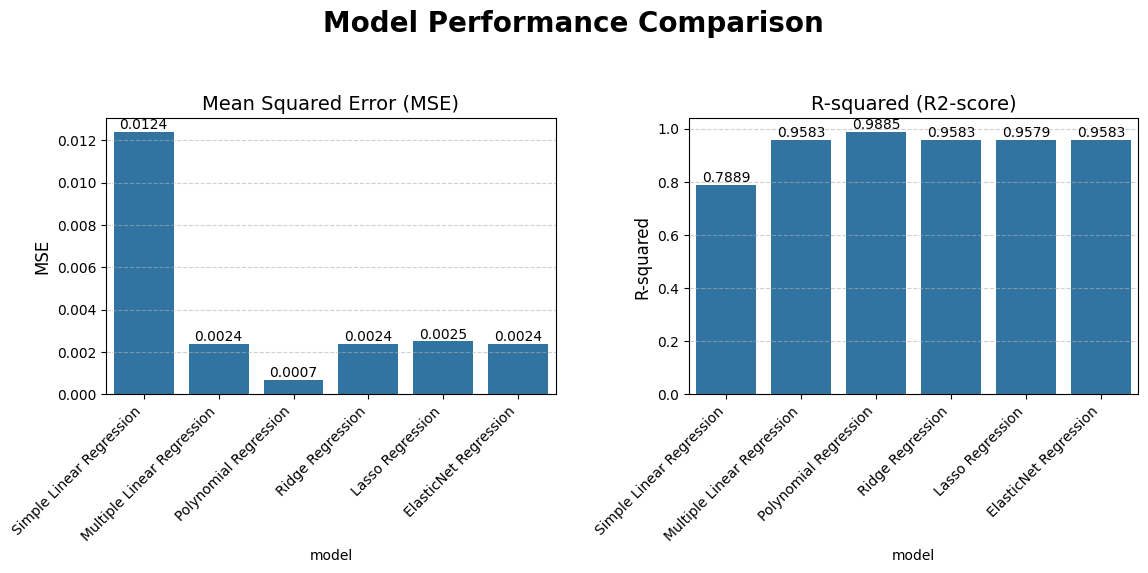

In [31]:
result_df = result_df.astype({'model': 'str', 'MSE': 'float64', 'R-squared': 'float64'})

plt.figure(figsize=(12,6))

ax1 = plt.subplot(1,2,1)

sns.barplot(x='model', y ="MSE", data=result_df, ax=ax1)
ax1.set_title('Mean Squared Error (MSE)', fontsize=14)
ax1.set_ylabel('MSE', fontsize=12)
ax1.bar_label(ax1.containers[0], label_type='edge')
ax1.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45,ha='right')

ax2 = plt.subplot(1,2,2)

sns.barplot(x="model", y="R-squared", data=result_df, ax=ax2)
ax2.set_title('R-squared (R2-score)', fontsize=14)
ax2.set_ylabel('R-squared', fontsize=12)
ax2.bar_label(ax2.containers[0], label_type='edge')
ax2.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')

plt.suptitle('Model Performance Comparison', fontsize=20, fontweight='bold')
plt.tight_layout(pad=2.5)
plt.show()